In [1]:
#Import Required libraries
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
TRAIN_PATH = '/kaggle/input/planets-dataset/planet/planet/train-jpg'
TEST_PATH = '/kaggle/input/planets-dataset/planet/planet/test-jpg'

TRAIN_CSV_PATH = '/kaggle/input/planets-dataset/planet/planet/train_classes.csv'
TEST_CSV_PATH = '/kaggle/input/planets-dataset/planet/planet/sample_submission.csv'

In [3]:
# Construct dataframes holding training and test data information
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print()
print(df_test.head())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road

   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [4]:
# the test set contains image names not present in the dataset
# we are going to remove them
def check_missing(image_folder, image_names):
    missing_images = []
    for image_name in image_names:
        
        image_path = os.path.join(image_folder, image_name)
        if not os.path.exists(image_path):
            missing_images.append(image_name)
    return missing_images

missing_train = check_missing(TRAIN_PATH, df_train["image_name"])
missing_test = check_missing(TEST_PATH, df_test["image_name"])

print("Number of missing images in train set: ", len(missing_train))
print("Number of missing images in test set: ", len(missing_test))

Number of missing images in train set:  0
Number of missing images in test set:  20522


In [5]:
# get the tags of the missing images to be used in submission file
# because the submission requires 61191 values
df_test_missing = df_test[df_test["image_name"].isin(missing_test)]

#  drop the missing images from the dataset for the model training
df_test = df_test[~df_test["image_name"].isin(missing_test)]

In [6]:
# check
missing_test = check_missing(TEST_PATH, df_test["image_name"])
print("Number of missing images in test set: ", len(missing_test))

Number of missing images in test set:  0


In [7]:
# These files are numpy Arrays with shape Nx1
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [8]:
# There are 17 Labels and each image is tagged with multiple labels
# Lets print out the unique label list

labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


We can see the difference between image resolution.
We did this plot to identify which is the best resolution to take.
32x32 seems very low. Best best is 128x128

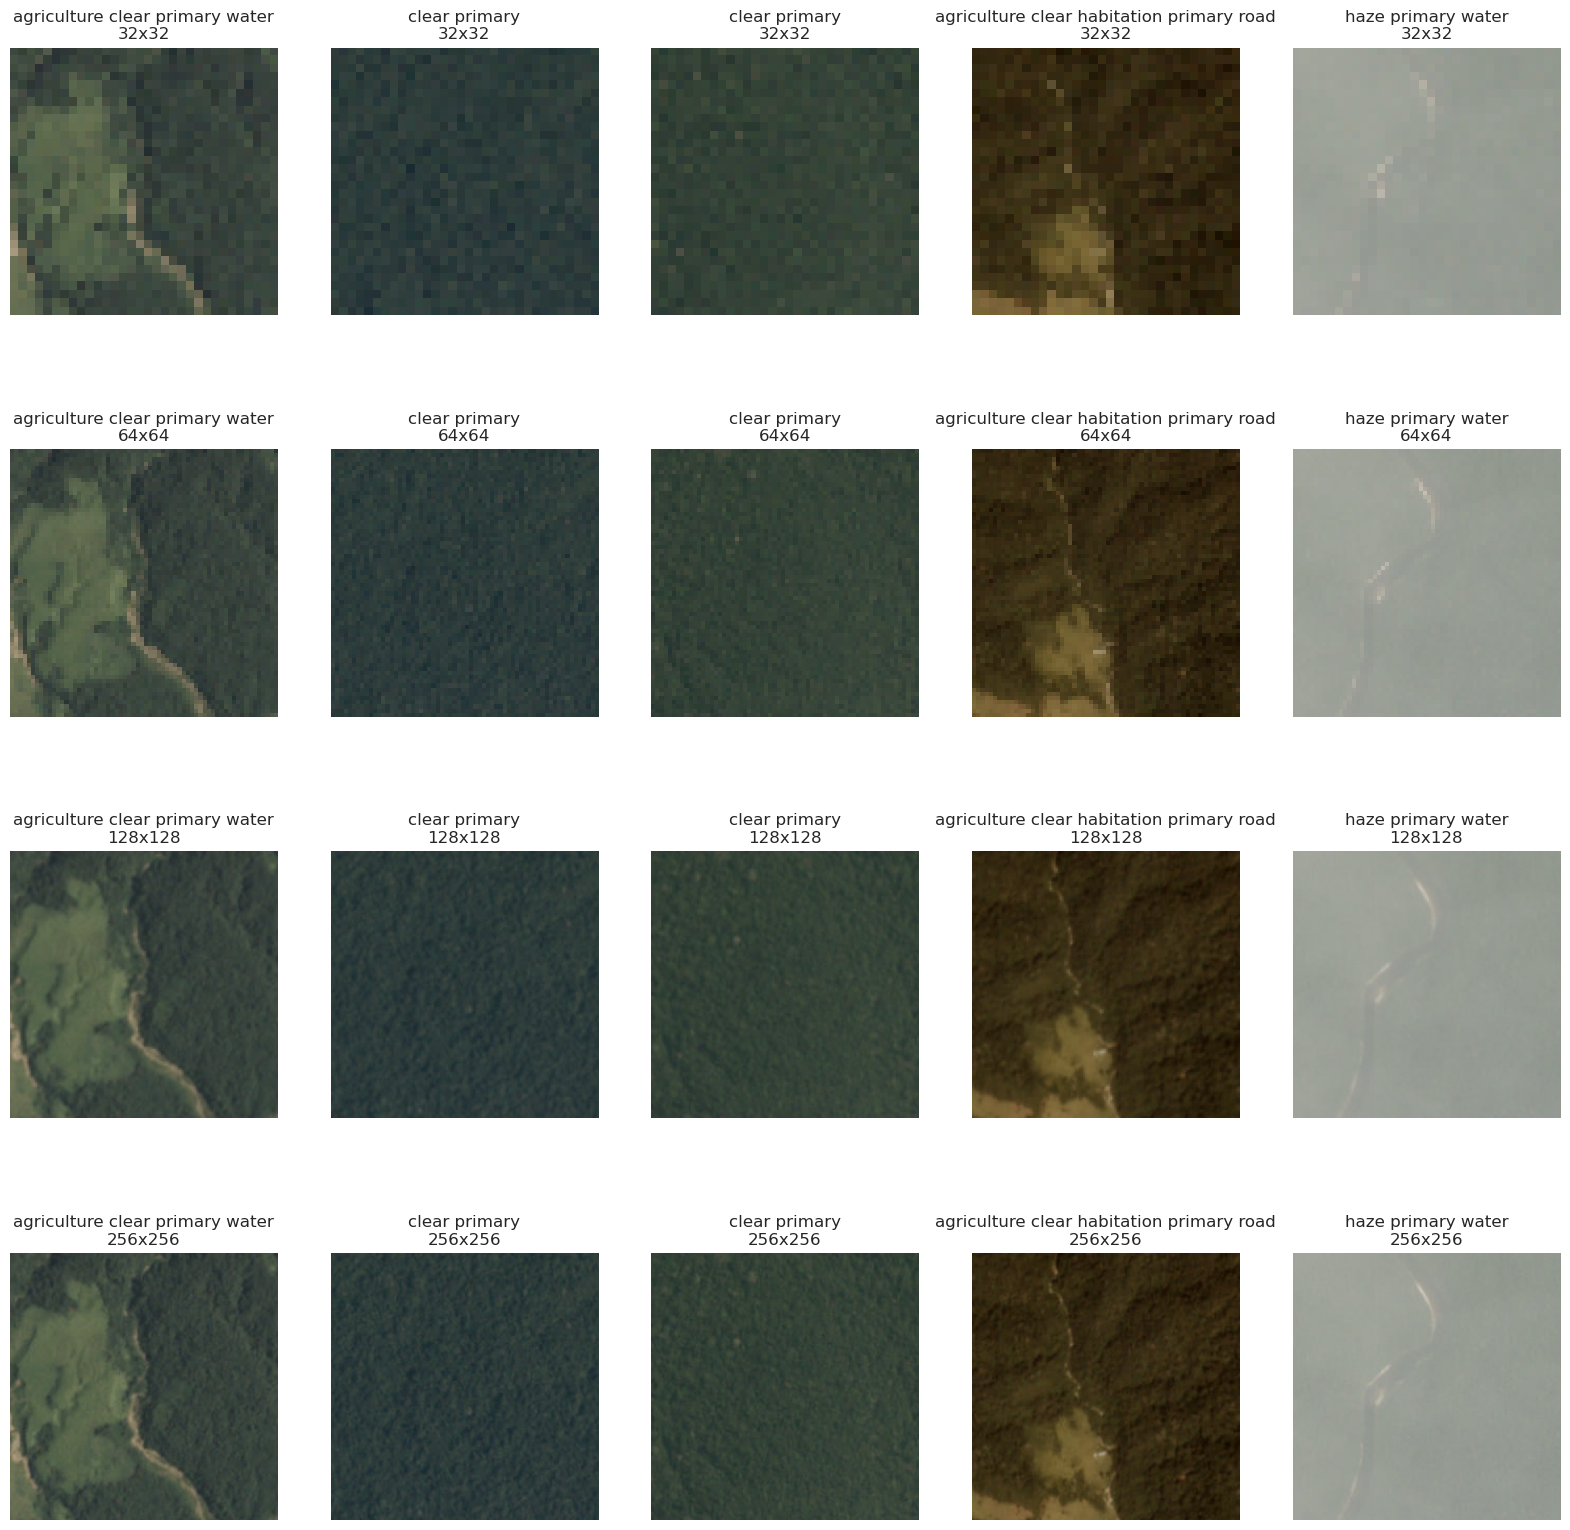

In [9]:
#Check some random images for quality check

plt.figure(figsize=(20, 20))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
        plt.axis('off')
    
plt.show()

conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


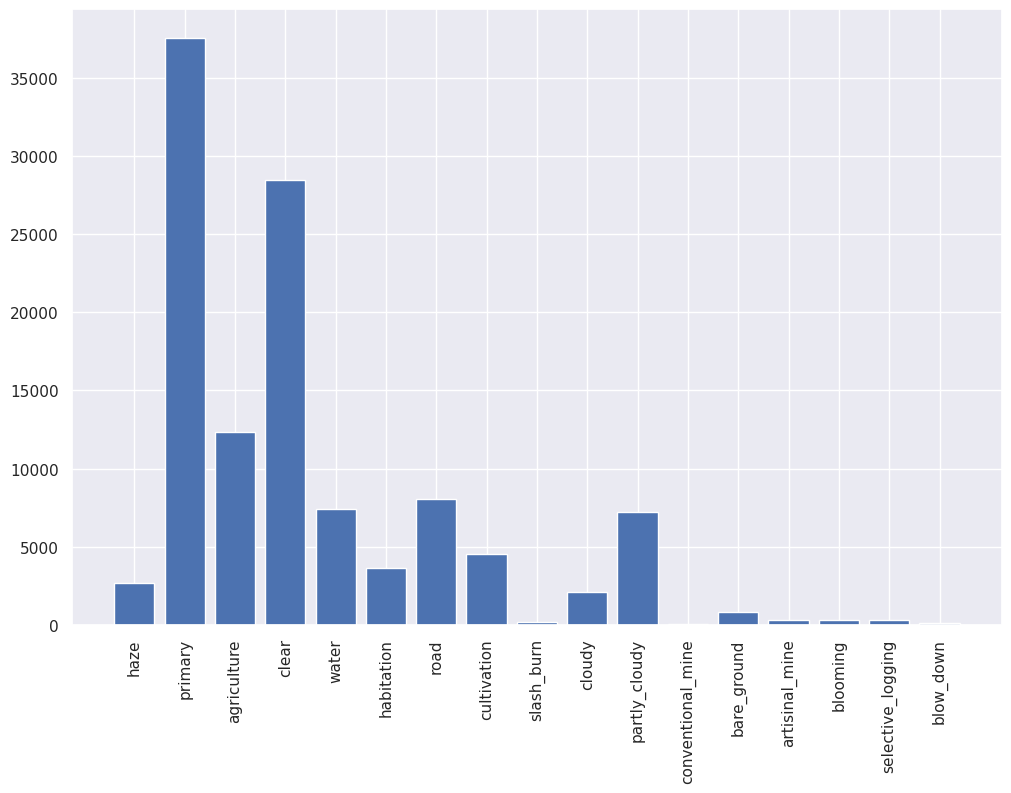

In [10]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [11]:
# Define learning curve and evaluation metric (f-2 Beta score):

def plot_learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [12]:
#Define CNN model architecture:

def create_model():

    # Load the pre-trained ResNet50 model, excluding the top layer
    base_model = ResNet50(weights='imagenet', include_top=False)

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a logistic layer with 17 classes (one for each class of deforestation)
    predictions = Dense(17, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the base model (ResNet50)
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = create_model()

clear_session()
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                             

In [13]:
# Define the model paramters here

INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
EPOCHS = 15
LR = 0.0001 # Learning Rate
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

#Train the model:
X_train, X_val, y_train_, y_val = train_test_split(X_train_files, y_train, test_size=0.25, random_state=42)

train_df = pd.DataFrame(list(zip(X_train, y_train_)), columns = ['image_name', 'tags'])
val_df = pd.DataFrame(list(zip(X_val, y_val)), columns = ['image_name', 'tags'])

train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory=TEST_PATH,
    x_col='image_name',
    y_col='tags',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
    shuffle=False,
)

best_weights_file = os.path.join('', 'weights_.h5')

clear_session()
model = create_model()

adam = Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(best_weights_file, monitor='fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)

model.load_weights(best_weights_file)

y_pred = model.predict(test_generator, workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)

Found 30359 validated image filenames belonging to 17 classes.
Found 10120 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames belonging to 17 classes.
Epoch 1/15
238/238 [==============================] - 239s 915ms/step - loss: 0.3007 - fbeta_score_K: 0.5219 - val_loss: 0.2544 - val_fbeta_score_K: 0.5504 - lr: 1.0000e-04
Epoch 2/15
238/238 [==============================] - 203s 841ms/step - loss: 0.2564 - fbeta_score_K: 0.5488 - val_loss: 0.2539 - val_fbeta_score_K: 0.5569 - lr: 1.0000e-04
Epoch 3/15
238/238 [==============================] - 196s 815ms/step - loss: 0.2559 - fbeta_score_K: 0.5497 - val_loss: 0.2533 - val_fbeta_score_K: 0.5529 - lr: 1.0000e-04
Epoch 4/15
238/238 [==============================] - 209s 868ms/step - loss: 0.2554 - fbeta_score_K: 0.5502 - val_loss: 0.2527 - val_fbeta_score_K: 0.5498 - lr: 1.0000e-04
Epoch 5/15
238/238 [==============================] - 189s 782ms/step - loss: 0.2549 - fbeta_score_K: 0.5501 - val_loss

In [14]:
result = pd.DataFrame(y_pred, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.257953,0.006619,0.016338,0.006925,0.002283,0.757135,0.051097,0.002196,0.119504,0.070562,0.069246,0.149865,0.934013,0.168779,0.007486,0.005161,0.170145
1,0.259128,0.006910,0.016536,0.007032,0.002320,0.779689,0.047029,0.002249,0.121797,0.075753,0.063546,0.158625,0.939237,0.177168,0.007649,0.005190,0.167557
2,0.456565,0.014890,0.021834,0.005367,0.002006,0.425515,0.051694,0.002612,0.130581,0.232769,0.039632,0.549901,0.911401,0.453447,0.007937,0.004751,0.362896
3,0.257310,0.006723,0.016467,0.006992,0.002314,0.762736,0.050288,0.002228,0.120179,0.071901,0.067874,0.152533,0.935176,0.170554,0.007594,0.005212,0.168254
4,0.372513,0.010257,0.018988,0.005860,0.002038,0.547693,0.053202,0.002381,0.126441,0.138677,0.051367,0.355282,0.918594,0.306158,0.007579,0.004868,0.283845


In [15]:
df_submit = df_test.copy()
df_submit.head()

,image_name,tags
0,test_0.jpg,"[primary, clear, agriculture, road, water]"
1,test_1.jpg,"[primary, clear, agriculture, road, water]"
2,test_2.jpg,"[primary, clear, agriculture, road, water]"
3,test_3.jpg,"[primary, clear, agriculture, road, water]"
4,test_4.jpg,"[primary, clear, agriculture, road, water]"


In [16]:
# Create label prediction and kaggle submission file 

preds = []
for i in range(result.shape[0]):
    a = result.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
df_submit['tags'] = preds
df_submit['image_name'] = df_submit['image_name'].astype(str).str.slice(stop=-4)
df_submit = pd.concat([df_submit, df_test_missing])
df_submit.to_csv('submit.csv', index=False)

In [17]:
df_submit.shape

(61191, 2)